In [1]:
# load libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

# set styles
sns.set_style("darkgrid")

In [2]:
def load_docs(dir_path):
    """
    - Parameters: dir_path (string) for a directory containing text files.
    - Returns: A list of dictionaries with keys file_name and text.
    """
    docs = []
    for file_name in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_name)
        if file_name.endswith(".html") and os.path.isfile(file_path):
            with open(file_path, "r+", encoding="utf-8") as file:
                text = file.read()
                current = {
                    "file_name": file_name,
                    "text": text
                }
                docs.append(current)
    return docs

html_docs = load_docs("data")
html_docs = sorted(html_docs, key = lambda d: d["file_name"])

In [3]:
def extract_paper_data(paper):
    """
    - Parameters: paper (BeautifulSoup object)
    - Returns: A dictionary of paper attributes.
    """
    title_anchor = paper.find("h3").find("a")
    author_info = paper.find(class_="gs_a")
    authors = author_info.text.split("-")[0].strip().split(", ")
    year = "".join(re.findall(r' \d{4}', author_info.text))[-4:]
    blurb = paper.find(class_="gs_rs")
    usage_data = paper.find(class_="gs_fl")
    citation_anchor = usage_data.find_all("a")[2]
    num_cites = int("".join(re.findall(r'\d*', citation_anchor.text)))
    
    return {
        "title": title_anchor.text if title_anchor else "",
        "authors": authors,
        "blurb": blurb.text if blurb else "",
        "citations": num_cites,
        "year": int(year) if year != "" else "",
        "link": title_anchor["href"] if title_anchor else ""
    }

def paper_df(paper_html):
    """
    - Parameters: paper_html (string of html text)
    - Returns: A Pandas DataFrame with data for each paper.
    """
    paper_soup = BeautifulSoup(paper_html, "html.parser")
    all_paper_data = []
    results = paper_soup.find(id="gs_res_ccl_mid")
    papers = results.find_all("div", class_="gs_ri")

    for paper in papers:
        paper_data = extract_paper_data(paper)
        all_paper_data.append(paper_data)
    
    return pd.DataFrame(all_paper_data)

def load_papers(html_docs):
    """
    - Parameters: html_docs (a list of dictionaries)
      Dictionaries must have "file_name" and "text" sections.
    - Returns: A Pandas DataFrame with data from each of the papers.
    """
    all_dfs = []
    for entry in html_docs:
        df = paper_df(entry["text"])
        all_dfs.append(df)
    
    full_df = pd.concat(all_dfs).sort_values("title")
    full_df = full_df.reset_index(drop=True)
    return full_df

def clean_papers(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe without rows that contain empty cells.
    """
    clean_df = papers_df.copy()
    clean_df = clean_df.replace("", np.nan, regex=True)
    clean_df = clean_df.dropna()
    return clean_df

papers = load_papers(html_docs)
papers = clean_papers(papers)

In [4]:
def print_df_info(df):
    """
    - Parameters: df (Pandas DataFrame)
    - Prints basic details about df.
    """
    print("DataFrame info:\n")
    print(df.info())
    print("\n")
    print(f'DataFrame shape: {df.shape}')
    print("\n")
    print("DataFrame head:")
    display(df.head())

print_df_info(papers)

DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 2 to 199
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      198 non-null    object
 1   authors    198 non-null    object
 2   blurb      198 non-null    object
 3   citations  198 non-null    int64 
 4   year       198 non-null    int64 
 5   link       198 non-null    object
dtypes: int64(2), object(4)
memory usage: 10.8+ KB
None


DataFrame shape: (198, 6)


DataFrame head:


,title,authors,blurb,citations,year,link
2,A Large Subcategorization Lexicon for Natural ...,"[A Korhonen, Y Krymolowski, T Briscoe]",We introduce a large computational subcategori...,116,2006,https://www.researchgate.net/profile/Ted_Brisc...
3,A bibliometric analysis of natural language pr...,"[X Chen, H Xie, FL Wang, Z Liu…]",Natural language processing (NLP) has become a...,57,2018,https://bmcmedinformdecismak.biomedcentral.com...
4,A broad-coverage natural language processing s...,[C Friedman],Natural language processing systems (NLP) that...,278,2000,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc2...
5,A comparison of word embeddings for the biomed...,"[Y Wang, S Liu, N Afzal, M Rastegar]",Background Word embeddings have been prevalent...,195,2018,https://www.sciencedirect.com/science/article/...
6,"A data model, knowledge base, and natural lang...",[H Sato],Most existing statistical databases are mere c...,211,1988,https://link.springer.com/chapter/10.1007/BFb0...


In [5]:
def get_citation_rate(citations, year_published):
    """
    - Parameters: citations (int), year_published (int)
    - Returns: The number of citations per year, since the year published.
    """
    current_year = pd.datetime.now().year
    years_since_publish = current_year - year_published
    return citations / (years_since_publish + 1)

papers["citation_rate"] = get_citation_rate(
    papers["citations"], papers["year"])
papers = papers[["title", "authors", "blurb", "citations",
                "citation_rate", "year", "link"]]
                
display(papers.head())

<ipython-input-5-6e5bd94b899d>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  current_year = pd.datetime.now().year


,title,authors,blurb,citations,citation_rate,year,link
2,A Large Subcategorization Lexicon for Natural ...,"[A Korhonen, Y Krymolowski, T Briscoe]",We introduce a large computational subcategori...,116,7.250000,2006,https://www.researchgate.net/profile/Ted_Brisc...
3,A bibliometric analysis of natural language pr...,"[X Chen, H Xie, FL Wang, Z Liu…]",Natural language processing (NLP) has become a...,57,14.250000,2018,https://bmcmedinformdecismak.biomedcentral.com...
4,A broad-coverage natural language processing s...,[C Friedman],Natural language processing systems (NLP) that...,278,12.636364,2000,https://www.ncbi.nlm.nih.gov/pmc/articles/pmc2...
5,A comparison of word embeddings for the biomed...,"[Y Wang, S Liu, N Afzal, M Rastegar]",Background Word embeddings have been prevalent...,195,48.750000,2018,https://www.sciencedirect.com/science/article/...
6,"A data model, knowledge base, and natural lang...",[H Sato],Most existing statistical databases are mere c...,211,6.205882,1988,https://link.springer.com/chapter/10.1007/BFb0...


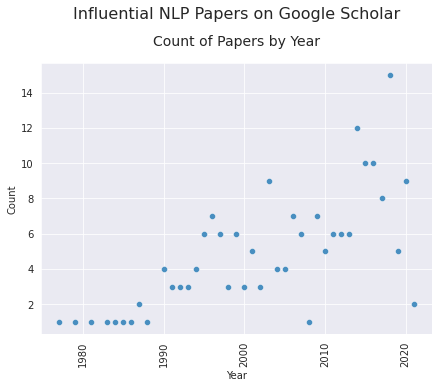

In [6]:
def plot_count_by_year(df, title, subtitle, year_col="year"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), 
      year_col (str)
    - Plots a scatterplot of the count of rows in df, grouped by year_col.
    """
    counts = df.groupby(year_col).size().reset_index(name="count")
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.scatterplot(
        x="year",
        y="count",
        data=counts,
        alpha=0.8,
        ax=ax
    )
    ax.set(
        xlabel="Year",
        ylabel="Count",
    )
    ax.text(
        x=0.5,
        y=1.15,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    ax.text(
        x=0.5,
        y=1.05,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    plt.xticks(rotation=90)
    plt.show()

title = "Influential NLP Papers on Google Scholar"
subtitle = "Count of Papers by Year"
plot_count_by_year(papers, title, subtitle)

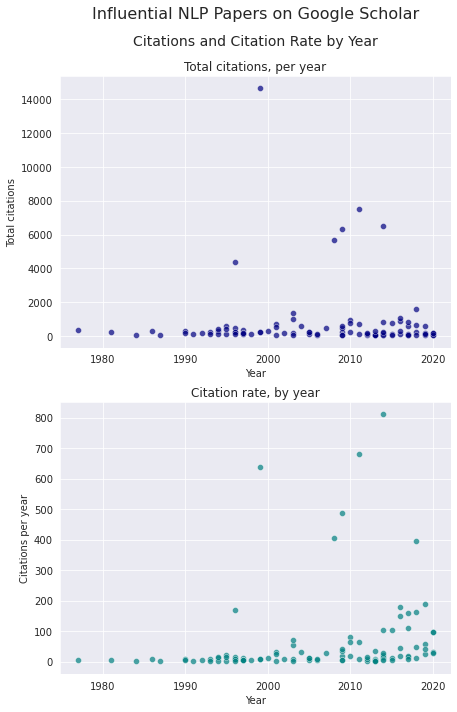

In [8]:
def plot_citations_by_year(df, title, subtitle, year_col="year"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), 
      year_col (str)
    - Plots a scatterplot of the count of citations and citation_rate 
      in df by year.
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(7, 11), nrows=2, ncols=1)

    # total citations
    sns.scatterplot(
        x="year",
        y="citations",
        data=df,
        alpha=0.7,
        color="navy",
        ax=ax0
    )
    ax0.set(
        xlabel="Year",
        ylabel="Total citations",
        title="Total citations, per year"
    )

    # total citation rate
    sns.scatterplot(
        x="year",
        y="citation_rate",
        data=df,
        alpha=0.7,
        color="teal",
        ax=ax1
    )
    ax1.set(
        xlabel="Year",
        ylabel="Citations per year",
        title="Citation rate, by year"
    )

    # titles
    ax0.text(
        x=0.5,
        y=1.20,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax0.transAxes
    )
    ax0.text(
        x=0.5,
        y=1.10,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax0.transAxes
    )
    plt.show()

subtitle = "Citations and Citation Rate by Year"
plot_citations_by_year(papers, title, subtitle)

In [14]:
def top_papers_by_col(papers_df, sort_col, limit=30):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with [limit] entries based on the highest values
      for sort_col in papers_df.
    """
    df = papers_df.copy()
    df = df.sort_values(by=sort_col, ascending=False)
    return df.head(limit)

display(top_papers_by_col(papers, "citations"))

,title,authors,blurb,citations,citation_rate,year,link
54,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,14680,638.260870,1999,https://books.google.com/books?hl=zh-CN&lr=&id...
99,Natural language processing (almost) from scratch,"[R Collobert, J Weston, L Bottou, M Karlen…]",We propose a unified neural network architectu...,7523,683.909091,2011,https://www.jmlr.org/papers/volume12/collobert...
178,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel…]",We describe the design and use of the Stanford...,6502,812.750000,2014,https://www.aclweb.org/anthology/P14-5010.pdf
130,Natural language processing with Python: analy...,"[S Bird, E Klein, E Loper]",This book offers a highly accessible introduct...,6363,489.461538,2009,https://books.google.com/books?hl=zh-CN&lr=&id...
18,A unified architecture for natural language pr...,"[R Collobert, J Weston]",We describe a single convolutional neural netw...,5690,406.428571,2008,https://dl.acm.org/doi/abs/10.1145/1390156.139...
10,A maximum entropy approach to natural language...,"[A Berger, SA Della Pietra, VJ Della Pietra]",The concept of maximum entropy can be traced b...,4386,168.692308,1996,https://dl.acm.org/doi/abs/10.5555/234285.234289
188,Transformation-based error-driven learning and...,[E Brill],"Recently, there has been a rebirth of empirici...",2439,90.333333,1995,https://dl.acm.org/doi/abs/10.5555/218355.218367
157,Recent trends in deep learning based natural l...,"[T Young, D Hazarika, S Poria…]",Deep learning methods employ multiple processi...,1597,399.250000,2018,https://ieeexplore.ieee.org/abstract/document/...
166,Sentiment analysis: Capturing favorability usi...,"[T Nasukawa, J Yi]",This paper illustrates a sentiment analysis ap...,1335,70.263158,2003,https://dl.acm.org/doi/abs/10.1145/945645.945658
27,Ask me anything: Dynamic memory networks for n...,"[A Kumar, O Irsoy, P Ondruska, M Iyyer…]",Most tasks in natural language processing can ...,1079,179.833333,2016,http://proceedings.mlr.press/v48/kumar16.html


In [15]:
display(top_papers_by_col(papers, "citation_rate"))

,title,authors,blurb,citations,citation_rate,year,link
178,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel…]",We describe the design and use of the Stanford...,6502,812.750000,2014,https://www.aclweb.org/anthology/P14-5010.pdf
99,Natural language processing (almost) from scratch,"[R Collobert, J Weston, L Bottou, M Karlen…]",We propose a unified neural network architectu...,7523,683.909091,2011,https://www.jmlr.org/papers/volume12/collobert...
54,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,14680,638.260870,1999,https://books.google.com/books?hl=zh-CN&lr=&id...
130,Natural language processing with Python: analy...,"[S Bird, E Klein, E Loper]",This book offers a highly accessible introduct...,6363,489.461538,2009,https://books.google.com/books?hl=zh-CN&lr=&id...
18,A unified architecture for natural language pr...,"[R Collobert, J Weston]",We describe a single convolutional neural netw...,5690,406.428571,2008,https://dl.acm.org/doi/abs/10.1145/1390156.139...
157,Recent trends in deep learning based natural l...,"[T Young, D Hazarika, S Poria…]",Deep learning methods employ multiple processi...,1597,399.250000,2018,https://ieeexplore.ieee.org/abstract/document/...
64,HuggingFace's Transformers: State-of-the-art n...,"[T Wolf, L Debut, V Sanh, J Chaumond…]",Recent progress in natural language processing...,589,196.333333,2019,https://arxiv.org/abs/1910.03771
27,Ask me anything: Dynamic memory networks for n...,"[A Kumar, O Irsoy, P Ondruska, M Iyyer…]",Most tasks in natural language processing can ...,1079,179.833333,2016,http://proceedings.mlr.press/v48/kumar16.html
10,A maximum entropy approach to natural language...,"[A Berger, SA Della Pietra, VJ Della Pietra]",The concept of maximum entropy can be traced b...,4386,168.692308,1996,https://dl.acm.org/doi/abs/10.5555/234285.234289
20,Allennlp: A deep semantic natural language pro...,"[M Gardner, J Grus, M Neumann, O Tafjord…]","This paper describes AllenNLP, a platform for ...",654,163.500000,2018,https://arxiv.org/abs/1803.07640


In [16]:
def get_author_counts(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with a count of each author in pandas_dF
    """
    authors = papers_df["authors"].apply(pd.Series
        ).stack().reset_index(name="author")
    authors = authors["author"]
    author_counts = authors.value_counts()
    author_counts = author_counts.rename_axis("author"
        ).reset_index(name="count")
    author_counts = author_counts.sort_values(by=["count", "author"], 
                                              ascending=[False, True])
    return author_counts

author_counts = get_author_counts(papers)
unique_authors = author_counts["author"].unique()

print(f"Total authors: {len(unique_authors)}\n\n")
print("Most prolific authors:")
display(author_counts.head(10))


Total authors: 407


Most prolific authors:


,author,count
0,C Friedman,9
1,KS Jones,5
2,E Brill,4
3,G Hripcsak,4
5,J Pustejovsky,3
6,JA Bateman,3
4,KB Cohen,3
17,AF Smeaton,2
33,BJ Grosz,2
22,C Manning,2


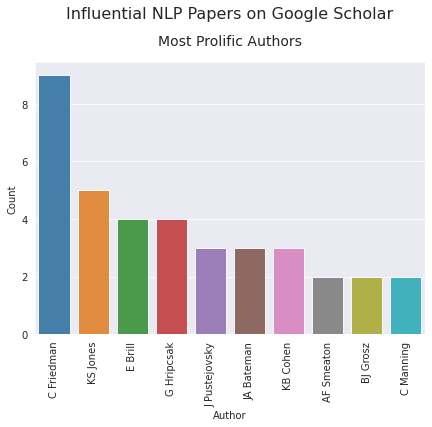

In [17]:
def plot_counts(df, title, subtitle, x_col, x_lab, y_col="count", y_lab="Count"):
    """
    - Parameters df (Pandas DataFrame), title (str), subtitle (str), x_col (str),
      x_lab (str), y_col (str), y_lab (str)
    - Plots a barplot of df using the provided x and y columns.
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.barplot(
        x=x_col,
        y=y_col,
        data=df,
        alpha=0.9,
        ax=ax
    )
    ax.set(
        xlabel=x_lab,
        ylabel=y_lab,
    )
    ax.text(
        x=0.5,
        y=1.15,
        s=title,
        fontsize=16,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    ax.text(
        x=0.5,
        y=1.05,
        s=subtitle,
        fontsize=14,
        ha="center",
        va="bottom",
        transform=ax.transAxes
    )
    plt.xticks(rotation=90)
    plt.show()

title = "Influential NLP Papers on Google Scholar"
subtitle = "Most Prolific Authors"
plot_counts(author_counts.head(10), title, subtitle, "author", "Author")

In [11]:
def filter_by_author(papers_df, author_name):
    """
    - Parameters: papers_df (Pandas DataFrame), author_name (str)
    - Returns: A dataframe with entries from papers_df by author.
    """
    return papers_df[papers_df["authors"].apply(
        lambda authors: author_name in authors)]

c_friedman_papers = filter_by_author(papers, "C Friedman")

display(c_friedman_papers[["title", "blurb", "citations", "year"]].head(10))

,title,blurb,citations,year
4,A broad-coverage natural language processing s...,Natural language processing systems (NLP) that...,278,2000
28,Automated encoding of clinical documents based...,Objective: The aim of this study was to develo...,578,2004
56,GENIES: a natural-language processing system f...,Abstract Systems that extract structured infor...,692,2001
102,Natural language processing and its future in ...,If accurate clinical information were availabl...,206,1999
118,Natural language processing in an operational ...,This paper describes a natural language text e...,149,1995
120,Natural language processing in health care and...,"After reading this chapter, you should know th...",47,2014
138,Natural language processing: state of the art ...,Natural language processing (NLP) is crucial f...,131,2013
159,Representing information in patient reports us...,Objective: To design a document model that pro...,155,1999
190,Unlocking clinical data from narrative reports...,Objective: To evaluate the automated detection...,433,1995


In [12]:
def get_author_citation_counts(papers_df):
    """
    - Parameters: papers_df (Pandas DataFrame)
    - Returns: A dataframe with a citation count for each author.
    """
    df = papers_df.explode("authors")
    df = df[["authors", "citations", "citation_rate"]]
    author_citations = df.groupby("authors").sum()
    author_citations = author_citations.reset_index()
    return author_citations

author_citation_counts = get_author_citation_counts(papers)
author_citation_counts = author_citation_counts.sort_values(
    "citations", ascending=False)
display(author_citation_counts.head(10))

,authors,citations,citation_rate
49,C Manning,14720,642.260870
130,H Schutze,14680,638.260870
163,J Weston,13213,1090.337662
294,R Collobert,13213,1090.337662
200,L Bottou,7523,683.909091
229,M Karlen…,7523,683.909091
52,CD Manning,7244,918.750000
174,JR Finkel…,6502,812.750000
144,J Bauer,6502,812.750000
243,M Surdeanu,6502,812.750000


In [13]:
c_manning_papers = filter_by_author(papers, "C Manning")
cd_manning_papers = filter_by_author(papers, "CD Manning")

display(c_manning_papers.append(cd_manning_papers))

,title,authors,blurb,citations,citation_rate,year,link
54,Foundations of statistical natural language pr...,"[C Manning, H Schutze]",Statistical approaches to processing natural l...,14680,638.26087,1999,https://books.google.com/books?hl=zh-CN&lr=&id...
88,Natural language processing,"[D Jurafsky, C Manning]",Much of the best work in the field combines tw...,40,4.00000,2012,https://nlp.cs.nyu.edu/meyers/montclair-class/
19,Advances in natural language processing,"[J Hirschberg, CD Manning]",Natural language processing employs computatio...,742,106.00000,2015,https://science.sciencemag.org/content/349/624...
178,The Stanford CoreNLP natural language processi...,"[CD Manning, M Surdeanu, J Bauer, JR Finkel…]",We describe the design and use of the Stanford...,6502,812.75000,2014,https://www.aclweb.org/anthology/P14-5010.pdf
